In [34]:
###########################################################
############### DATA EXTRACTION & CALCULATIONS ############
###########################################################

import sys
import os 
sys.path.append("/home/j/jphickey/josephmo/scratch/pencil-ind/python")
os.environ["PATH"] += os.pathsep +'/home/j/jphickey/josephmo/scratch/pencil-ind/bin'

import numpy as np
from matplotlib import pyplot as plt
import pylab as plt
import matplotlib
matplotlib.rcParams['savefig.directory'] = ''
import math
import pickle
from scipy.interpolate import interp1d
import matplotlib as mpl
from myFigs import set_size,set_square,set_stretch,set_almoststretch

width=300
nice_fonts = {
        "font.family": 'serif',
        "axes.labelsize": 9,
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}
mpl.rcParams.update(nice_fonts)

FIRSTSNAP = 0
FINALSNAP = 410
snapstep = 1
data_length=int((FINALSNAP-FIRSTSNAP)/snapstep)

num_part = 500

#############################################################################
################### SAVE .PICKLE DATA INTO LOCAL VARIABLES ##################
#############################################################################

#complete list of all of the cases
cases = ['st01','st1','st10','st01_backflow_u001','st01_backflow_u0025','st01_backflow_u005',
       'st01_backflow_u0075','st1_gap1','st1_gap2', 'st1_backflow_u001', 'st1_backflow_u0025',
       'st1_backflow_u005', 'st1_backflow_u0075', 'st01_gap1', 'st01_gap2']

plotlabels = ['S01U0', 'S1U0', 'S10U0', 'S01U10', 'S01U25', 'S01U50', 'S01U75', 'S1U0G', 'S1U0G2',
             'S1U10', 'S1U25', 'S1U50', 'S1U75', 'S01U0G', 'S01U0G2']

num_cases = len(cases)

#last index corresponds to the respective case, i.e. 0 corresponds to st01
part_xp = np.zeros((num_part,data_length,num_cases))
part_yp = np.zeros((num_part,data_length,num_cases))
part_zp = np.zeros((num_part,data_length,num_cases))
part_vpx = np.zeros((num_part,data_length,num_cases))
part_vpy = np.zeros((num_part,data_length,num_cases))
part_vpz = np.zeros((num_part,data_length,num_cases))
part_vpmag = np.zeros((num_part,data_length,num_cases))

part_yp_mean_neg = np.zeros((data_length,num_cases))
part_yp_mean_pos = np.zeros((data_length,num_cases))
part_zp_mean = np.zeros((data_length,num_cases))
part_vpy_mean_neg = np.zeros((data_length,num_cases))
part_vpy_mean_pos = np.zeros((data_length,num_cases))
part_vpmag_mean = np.zeros((data_length,num_cases))

time = np.zeros(data_length)

case_counter = 0
for case in cases:
    pickle_in=open(case+'.pickle','rb')
    data=pickle.load(pickle_in)
    pickle_in.close()

    for i in range(num_part): #for each particle
        for j in range(data_length): #for each moment in time
            part_xp[i,j,case_counter] = data['part_xp'][i,j]
            part_yp[i,j,case_counter] = data['part_yp'][i,j]
            part_zp[i,j,case_counter] = data['part_zp'][i,j]
            part_vpx[i,j,case_counter] = data['part_vpx'][i,j]
            part_vpy[i,j,case_counter] = data['part_vpy'][i,j]
            part_vpz[i,j,case_counter] = data['part_vpz'][i,j]
            part_vpmag[i,j,case_counter] = data['part_vpmag'][i,j]
            
    for j in range(data_length): #for each moment in time
            part_yp_mean_neg[j,case_counter] = data['part_yp_mean_neg'][j]
            part_yp_mean_pos[j,case_counter] = data['part_yp_mean_pos'][j]
            part_zp_mean[j,case_counter] = data['part_zp_mean'][j]
            part_vpy_mean_neg[j,case_counter] = data['part_vpy_mean_neg'][j]
            part_vpy_mean_pos[j,case_counter] = data['part_vpy_mean_pos'][j]
            part_vpmag_mean[j,case_counter] = data['part_vpmag_mean'][j]
            time[j] = data['time'][j]
            
    case_counter += 1

#############################################
############### DATA CORRECTIONS ############
#############################################

#correcting the z-displacement data for all particles
for n in [6, 12]: #cases 6 and 12
    for i in range(num_part):
        for j in range(data_length):
            if j > 200 and part_zp[i,j,n] < 0:
                part_zp[i,j,n] = 2*math.pi + (2*math.pi - np.abs(part_zp[i,j,n]))
    #resetting the zp_mean for this case
    for j in range(data_length):
        part_zp_mean[j,n] = 0
    for j in range(data_length):
        for i in range(num_part):
            part_zp_mean[j,n] += part_zp[i,j,n]
        part_zp_mean[j,n] /= num_part

for n in [13, 14]:
    for j in range(data_length):
        neg_yp_indexes=np.where(part_yp[:,j,n]<0)
        part_yp_mean_neg[j,n] = np.mean(part_yp[neg_yp_indexes,j,n])

##############################################
############### CALCULATED VALUES ############
##############################################

part_yp_mean_all = np.zeros((data_length,num_cases))
part_xp_mean = np.zeros((data_length,num_cases))

case_counter = 0
for case in cases:
    for j in range(data_length):
        part_yp_mean_all[j,case_counter] = (part_yp_mean_pos[j,case_counter] + np.abs(part_yp_mean_neg[j,case_counter])) / 2
        part_xp_mean[j,case_counter] = np.mean(part_xp[:,j,case_counter])
    case_counter += 1

variance_xp = np.zeros((data_length,len(cases)))
std_dev_xp = np.zeros((data_length,len(cases))) 
variance_yp = np.zeros((data_length,len(cases)))
std_dev_yp = np.zeros((data_length,len(cases)))
variance_zp = np.zeros((data_length,len(cases)))
std_dev_zp = np.zeros((data_length,len(cases)))

case_counter = 0
for case in cases:
    for j in range(data_length):
        for i in range(num_part):
            variance_xp[j,case_counter] += (np.abs(part_xp[i,j,case_counter]) - part_xp_mean[j,case_counter])**2
            variance_yp[j,case_counter] += (np.abs(part_yp[i,j,case_counter]) - part_yp_mean_all[j,case_counter])**2
            variance_zp[j,case_counter] += (np.abs(part_zp[i,j,case_counter]) - part_zp_mean[j,case_counter])**2
        variance_xp[j,case_counter] /= num_part
        variance_yp[j,case_counter] /= num_part
        variance_zp[j,case_counter] /= num_part
        std_dev_xp[j,case_counter] = math.sqrt(variance_xp[j,case_counter])
        std_dev_yp[j,case_counter] = math.sqrt(variance_yp[j,case_counter])
        std_dev_zp[j,case_counter] = math.sqrt(variance_xp[j,case_counter])
    case_counter += 1

plus_std_dev_xp = np.zeros((data_length,len(cases)))
minus_std_dev_xp = np.zeros((data_length,len(cases)))
plus_std_dev_yp = np.zeros((data_length,len(cases)))
minus_std_dev_yp = np.zeros((data_length,len(cases)))
plus_std_dev_zp = np.zeros((data_length,len(cases)))
minus_std_dev_zp = np.zeros((data_length,len(cases)))

case_counter = 0
for case in cases:
    for j in range(data_length):
        plus_std_dev_xp[j,case_counter] = part_xp_mean[j,case_counter] + std_dev_xp[j,case_counter]
        minus_std_dev_xp[j,case_counter] = part_xp_mean[j,case_counter] - std_dev_xp[j,case_counter]
        plus_std_dev_yp[j,case_counter] = part_yp_mean_all[j,case_counter] + std_dev_yp[j,case_counter]
        minus_std_dev_yp[j,case_counter] = part_yp_mean_all[j,case_counter] - std_dev_yp[j,case_counter]
        plus_std_dev_zp[j,case_counter] = part_zp_mean[j,case_counter] + std_dev_zp[j,case_counter]
        minus_std_dev_zp[j,case_counter] = part_zp_mean[j,case_counter] - std_dev_zp[j,case_counter]
    case_counter += 1

print("Process completed.")

Process completed.


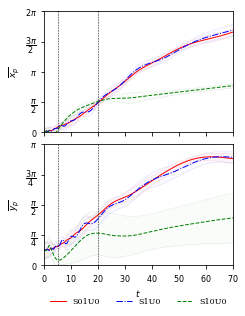

In [35]:
###############################################################################
############ FIGURE 2: PARTICLE MEAN POSITION + STD. DEV. VS. TIME ############
###############################################################################

#######################################
############ FIGURE SIZING ############
#######################################

fraction = 1
# Width of figure
fig_width_pt = width * fraction
# Convert from pt to inches
inches_per_pt = 1 / 72.27
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2
# Figure width in inches
fig_width_in = 3+3/8
# Figure height in inches
fig_height_in = fig_width_in * golden_ratio * 2 + 0.5
fig_dim = (fig_width_in, fig_height_in)

##################################
############ PLOTTING ############
##################################

save = 'yes'

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = fig_dim)

ax1.fill_between(time, plus_std_dev_zp[:,0]+math.pi, minus_std_dev_zp[:,0]+math.pi,
                 facecolor="red", #fill color
                 color='red', #outline color
                 alpha=0.02) #fill transparency

ax1.fill_between(time, plus_std_dev_zp[:,1]+math.pi, minus_std_dev_zp[:,1]+math.pi,
                 facecolor="blue",
                 color='blue',
                 alpha=0.02)

ax1.fill_between(time, plus_std_dev_zp[:,2]+math.pi, minus_std_dev_zp[:,2]+math.pi,
                 facecolor="green",
                 color='green',
                 alpha=0.02)

ax1.plot(time,plus_std_dev_zp[:,0]+math.pi, 'r-', alpha=0.25, lw = 0.2, label = '')
ax1.plot(time,minus_std_dev_zp[:,0]+math.pi, 'r-', alpha=0.25, lw = 0.2, label = '')
ax1.plot(time,plus_std_dev_zp[:,1]+math.pi, 'b-', alpha=0.25, lw = 0.2, label = '')
ax1.plot(time,minus_std_dev_zp[:,1]+math.pi, 'b-', alpha=0.25, lw = 0.2, label = '')
ax1.plot(time,plus_std_dev_zp[:,2]+math.pi, 'g-', alpha=0.25, lw = 0.2, label = '')
ax1.plot(time,minus_std_dev_zp[:,2]+math.pi, 'g-', alpha=0.25, lw = 0.2, label = '')
ax1.plot(time,part_zp_mean[:,0]+math.pi, 'r-', lw = 1, label=plotlabels[0])
ax1.plot(time,part_zp_mean[:,1]+math.pi, 'b-.', lw = 1, label=plotlabels[1])
ax1.plot(time,part_zp_mean[:,2]+math.pi, 'g--', lw = 1, label=plotlabels[2])
ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)

ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi])
ax1.set_yticklabels([r'$0$', r'$\dfrac{\pi}{2}$', r'$\pi$', r'$\dfrac{3\pi}{2}$', r'$2\pi$'])

ax2.fill_between(time, plus_std_dev_yp[:,0], minus_std_dev_yp[:,0],
                 facecolor="red",
                 color='red',
                 alpha=0.02)

ax2.fill_between(time, plus_std_dev_yp[:,1], minus_std_dev_yp[:,1],
                 facecolor="blue",
                 color='blue',
                 alpha=0.02)

ax2.fill_between(time, plus_std_dev_yp[:,2], minus_std_dev_yp[:,2],
                 facecolor="green",
                 color='green',
                 alpha=0.02)

ax2.plot(time,plus_std_dev_yp[:,0], 'r-', alpha=0.25, lw = 0.2, label = '')
ax2.plot(time,minus_std_dev_yp[:,0], 'r-', alpha=0.25, lw = 0.2, label = '')
ax2.plot(time,plus_std_dev_yp[:,1], 'b-', alpha=0.25, lw = 0.2, label = '')
ax2.plot(time,minus_std_dev_yp[:,1], 'b-', alpha=0.25, lw = 0.2, label = '')
ax2.plot(time,plus_std_dev_yp[:,2], 'g-', alpha=0.25, lw = 0.2, label = '')
ax2.plot(time,minus_std_dev_yp[:,2], 'g-', alpha=0.25, lw = 0.2, label = '')
ax2.plot(time,part_yp_mean_all[:,0], 'r-', lw = 1, label=plotlabels[0])
ax2.plot(time,part_yp_mean_all[:,1], 'b-.', lw = 1, label=plotlabels[1])
ax2.plot(time,part_yp_mean_all[:,2], 'g--', lw = 1, label=plotlabels[2])

ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.set_xlim(0,time[350])
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\dfrac{\pi}{4}$', r'$\dfrac{\pi}{2}$', r'$\dfrac{3\pi}{4}$', r'$\pi$'])
ax2.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)

ax2.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
ax2.set_xticklabels([r'$0$', r'$10$', r'$20$', r'$30$', r'$40$', r'$50$', r'$60$', r'$70$'])

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.30),
          ncol=3, frameon = False, fancybox=False, shadow=False, framealpha = 1, edgecolor = '0')

plt.subplots_adjust(wspace=0, hspace=0.1)

if save=='yes':
    plt.savefig('mean_xp_yp_vs_t_stokes.pdf',bbox_inches='tight')

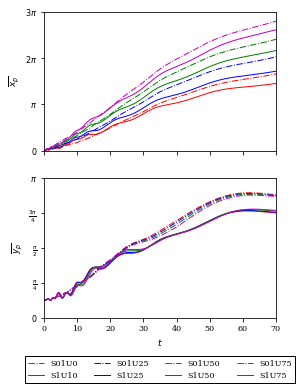

In [36]:
####################################################################################################
###################### FIGURE 4: MEAN y_p & z_p VS. t: ST01 & ST1 CHANNEL FLOW #####################
####################################################################################################

#######################################
############ FIGURE SIZING ############
#######################################

fraction = 1
# Width of figure
fig_width_pt = width * fraction
# Convert from pt to inches
inches_per_pt = 1 / 72.27
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2
# Figure width in inches
fig_width_in = fig_width_pt * inches_per_pt
# Figure height in inches
fig_height_in = fig_width_in * golden_ratio * 2 + 0.5
fig_dim = (fig_width_in, fig_height_in)

##################################
############ PLOTTING ############
##################################

save = 'yes'

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = fig_dim)

ax1.plot(time,part_zp_mean[:,0]+math.pi, 'r-.', lw =1, label=plotlabels[0])
ax1.plot(time,part_zp_mean[:,9]+math.pi, 'r-', lw = 1, label=plotlabels[9])
ax1.plot(time,part_zp_mean[:,4]+math.pi, 'b-.', lw = 1, label=plotlabels[4])
ax1.plot(time,part_zp_mean[:,10]+math.pi, 'b-', lw = 1, label=plotlabels[10])
ax1.plot(time,part_zp_mean[:,5]+math.pi, 'g-.', lw = 1, label=plotlabels[5])
ax1.plot(time,part_zp_mean[:,11]+math.pi, 'g-', lw = 1, label=plotlabels[11])
ax1.plot(time,part_zp_mean[:,6]+math.pi, 'm-.', lw = 1, label=plotlabels[6])
ax1.plot(time,part_zp_mean[:,12]+math.pi, 'm-', lw = 1, label=plotlabels[12])
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,3*math.pi)
ax1.set_yticks(ticks = [0, math.pi, 2*math.pi, 3*math.pi])
ax1.set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$'])

ax2.plot(time,part_yp_mean_all[:,0], 'r-.', lw =1, label=plotlabels[0])
ax2.plot(time,part_yp_mean_all[:,9], 'r-', lw = 1, label=plotlabels[9])
ax2.plot(time,part_yp_mean_all[:,4], 'b-.', lw = 1, label=plotlabels[4])
ax2.plot(time,part_yp_mean_all[:,10], 'b-', lw = 1, label=plotlabels[10])
ax2.plot(time,part_yp_mean_all[:,5], 'g-.', lw = 1, label=plotlabels[5])
ax2.plot(time,part_yp_mean_all[:,11], 'g-', lw = 1, label=plotlabels[11])
ax2.plot(time,part_yp_mean_all[:,6], 'm-.', lw = 1, label=plotlabels[6])
ax2.plot(time,part_yp_mean_all[:,12], 'm-', lw = 1, label=plotlabels[12])
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.set_xlim(0,time[350])
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          ncol=4, fancybox=False, shadow=False, framealpha = 1, edgecolor = '0')

if save=='yes':
    plt.savefig('mean_xp_yp_vs_t_st01_and_st1_channel.pdf',bbox_inches='tight')

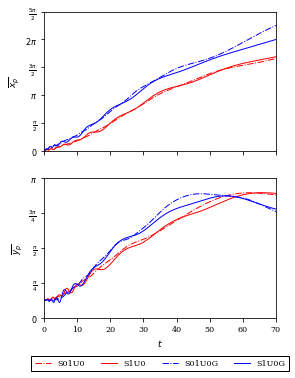

In [37]:
###################################################################################################
################### FIGURE 5: MEAN y_p & z_p vs. t: ST01 & ST1 GAP VS. NO GAP #####################
###################################################################################################

#######################################
############ FIGURE SIZING ############
#######################################

fraction = 1
# Width of figure
fig_width_pt = width * fraction
# Convert from pt to inches
inches_per_pt = 1 / 72.27
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2
# Figure width in inches
fig_width_in = fig_width_pt * inches_per_pt
# Figure height in inches
fig_height_in = fig_width_in * golden_ratio * 2 + 0.5
fig_dim = (fig_width_in, fig_height_in)

##################################
############ PLOTTING ############
##################################

save = 'yes'

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = fig_dim)

ax1.plot(time,part_zp_mean[:,0]+math.pi, 'r-.', lw =1, label=plotlabels[0])
ax1.plot(time,part_zp_mean[:,1]+math.pi, 'r-', lw = 1, label=plotlabels[1])
ax1.plot(time,part_zp_mean[:,13]+math.pi, 'b-.', lw = 1, label=plotlabels[13])
ax1.plot(time,part_zp_mean[:,7]+math.pi, 'b-', lw = 1, label=plotlabels[7])
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2.5*math.pi)
ax1.set_yticks(ticks = [0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi, 5*math.pi/2])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$'])

ax2.plot(time,part_yp_mean_all[:,0], 'r-.', lw =1, label=plotlabels[0])
ax2.plot(time,part_yp_mean_all[:,1], 'r-', lw = 1, label=plotlabels[1])
ax2.plot(time,part_yp_mean_all[:,13], 'b-.', lw = 1, label=plotlabels[13])
ax2.plot(time,part_yp_mean_all[:,7], 'b-', lw = 1, label=plotlabels[7])
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.set_xlim(0,time[350])
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          ncol=4, fancybox=False, shadow=False, framealpha = 1, edgecolor = '0')

if save=='yes':
    plt.savefig('mean_xp_yp_vs_t_st01_and_st1_gap.pdf',bbox_inches='tight')

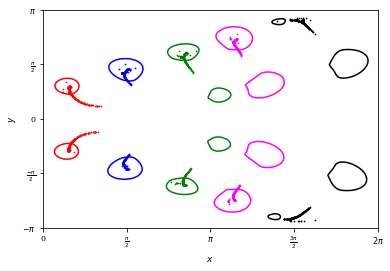

In [38]:
##################################################################
################### CONTOUR SCATTER FOR ST01 #####################
##################################################################

##################################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################

from lambda2 import *

pickle_in=open('st01_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

#in seconds
save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

##################################
############ PLOTTING ############
##################################
          
Y, Z = np.meshgrid(y, z)

plt.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

#Note for time indexing: 1 index = 0.2 seconds, i.e. index of 50 corresponds to 10 seconds
plt.scatter(part_zp[:,50,0],part_yp[:,50,0], s = 0.5, color = 'red')
plt.scatter(part_zp[:,100,0],part_yp[:,100,0], s = 0.5, color = 'blue')
plt.scatter(part_zp[:,150,0],part_yp[:,150,0], s = 0.5, color = 'green')
plt.scatter(part_zp[:,200,0],part_yp[:,200,0], s = 0.5, color = 'magenta')
plt.scatter(part_zp[:,300,0],part_yp[:,300,0], s = 0.5, color = 'black')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-math.pi,math.pi)
plt.ylim(-math.pi,math.pi)

ytick_pos= np.linspace(-math.pi,math.pi,5)
ylabels = [r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(ytick_pos, ylabels)
xtick_pos= np.linspace(-math.pi,math.pi,5)
xlabels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(xtick_pos, xlabels)

plt.savefig('st01_scatter_isosurfaces.pdf',bbox_inches='tight')

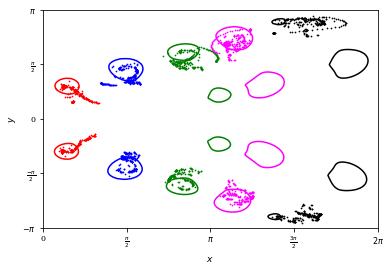

In [39]:
##################################################################
################### CONTOUR SCATTER FOR ST1 ######################
##################################################################

##################################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################

from lambda2 import *

pickle_in=open('st1_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

##################################
############ PLOTTING ############
##################################

Y, Z = np.meshgrid(y, z)

plt.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

plt.scatter(part_zp[:,50,1],part_yp[:,50,1], s = 0.5, color = 'red')
plt.scatter(part_zp[:,100,1],part_yp[:,100,1], s = 0.5, color = 'blue')
plt.scatter(part_zp[:,150,1],part_yp[:,150,1], s = 0.5, color = 'green')
plt.scatter(part_zp[:,200,1],part_yp[:,200,1], s = 0.5, color = 'magenta')
plt.scatter(part_zp[:,300,1],part_yp[:,300,1], s = 0.5, color = 'black')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-math.pi,math.pi)
plt.ylim(-math.pi,math.pi)

ytick_pos= np.linspace(-math.pi,math.pi,5)
ylabels = [r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(ytick_pos, ylabels)
xtick_pos= np.linspace(-math.pi,math.pi,5)
xlabels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(xtick_pos, xlabels)

plt.savefig('st1_scatter_isosurfaces.pdf',bbox_inches='tight')

Done


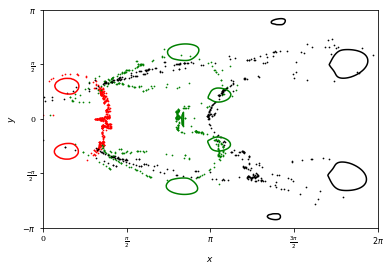

In [40]:
##################################################################
################### CONTOUR SCATTER FOR ST10 #####################
##################################################################

##################################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################
from lambda2 import *

pickle_in=open('st10_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

##################################
############ PLOTTING ############
##################################

Y, Z = np.meshgrid(y, z)

plt.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

plt.scatter(part_zp[:,50,2],part_yp[:,50,2], s = 0.5, color = 'red')
plt.scatter(part_zp[:,150,2],part_yp[:,150,2], s = 0.5, color = 'green')
plt.scatter(part_zp[:,300,2],part_yp[:,300,2], s = 0.5, color = 'black')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-math.pi,math.pi)
plt.ylim(-math.pi,math.pi)

ytick_pos= np.linspace(-math.pi,math.pi,5)
ylabels = [r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(ytick_pos, ylabels)
xtick_pos= np.linspace(-math.pi,math.pi,5)
xlabels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(xtick_pos, xlabels)

plt.savefig('st10_scatter_isosurfaces.pdf',bbox_inches='tight')

print('Done')

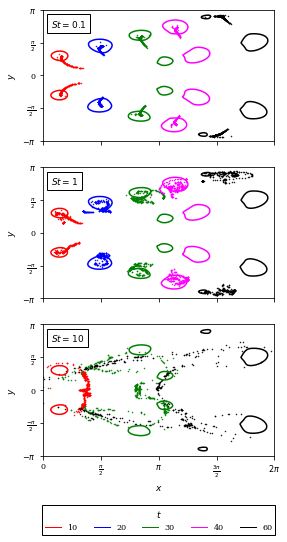

In [41]:
####################################################################
################### FIGURE 3: CONTOUR SCATTER ######################
####################################################################

#######################################
############ FIGURE SIZING ############
#######################################

fraction = 1
# Width of figure
fig_width_pt = width * fraction
# Convert from pt to inches
inches_per_pt = 1 / 72.27
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2
# Figure width in inches
fig_width_in = fig_width_pt * inches_per_pt
# Figure height in inches
fig_height_in = fig_width_in * golden_ratio * 3 + 0.5
fig_dim = (fig_width_in, fig_height_in)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize = fig_dim)

##############################
############ ST01 ############
##############################
from lambda2 import *

pickle_in=open('st01_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax1.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax1.scatter(part_zp[:,50,0],part_yp[:,50,0], s = 0.25, color = 'red')
ax1.scatter(part_zp[:,100,0],part_yp[:,100,0], s = 0.25, color = 'blue')
ax1.scatter(part_zp[:,150,0],part_yp[:,150,0], s = 0.25, color = 'green')
ax1.scatter(part_zp[:,200,0],part_yp[:,200,0], s = 0.25, color = 'magenta')
ax1.scatter(part_zp[:,300,0],part_yp[:,300,0], s = 0.25, color = 'black')

ax1.set_ylabel(r'$y$')
ax1.set_xlim(-math.pi,math.pi)
ax1.set_ylim(-math.pi,math.pi)

ax1.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax1.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 0.1$', loc=2)
ax1.add_artist(anchored_text)

##############################
############ ST1 #############
##############################
from lambda2 import *

pickle_in=open('st1_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax2.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax2.scatter(part_zp[:,50,1],part_yp[:,50,1], s = 0.25, color = 'red')
ax2.scatter(part_zp[:,100,1],part_yp[:,100,1], s = 0.25, color = 'blue')
ax2.scatter(part_zp[:,150,1],part_yp[:,150,1], s = 0.25, color = 'green')
ax2.scatter(part_zp[:,200,1],part_yp[:,200,1], s = 0.25, color = 'magenta')
ax2.scatter(part_zp[:,300,1],part_yp[:,300,1], s = 0.25, color = 'black')

ax2.set_ylabel(r'$y$')
ax2.set_xlim(-math.pi,math.pi)
ax2.set_ylim(-math.pi,math.pi)

ax2.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax2.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 1$', loc=2)
ax2.add_artist(anchored_text)

##############################
############ ST10 ############
##############################

from lambda2 import *

pickle_in=open('st10_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax3.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax3.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax3.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax3.scatter(part_zp[:,50,2],part_yp[:,50,2], s = 0.25, color = 'red')
ax3.scatter(part_zp[:,150,2],part_yp[:,150,2], s = 0.25, color = 'green')
ax3.scatter(part_zp[:,300,2],part_yp[:,300,2], s = 0.25, color = 'black')

ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$y$')
ax3.set_xlim(-math.pi,math.pi)
ax3.set_ylim(-math.pi,math.pi)

ax3.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax3.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

ax3.set_xticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax3.set_xticklabels([r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 10$', loc=2)
ax3.add_artist(anchored_text)

from matplotlib.lines import Line2D
colors = ['red', 'blue', 'green', 'magenta', 'black']
lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in colors]
labels = ['10', '20', '30','40','60']

plt.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, -0.35),
          ncol=5, title = '$t$', fancybox=False, shadow=False, framealpha = 1, edgecolor = '0')

plt.savefig('st01_st1_st10_scatter_isosurfaces.pdf',bbox_inches='tight')